In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [7]:
import uproot
uproot.default_library = "np"

In [8]:
import os.path

In [296]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [9]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    "DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [10]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

### Truthing

In [11]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])

In [12]:
B_features = [
    "B_plus_TRUEPT",
    "B_plus_TRUEP_X",
    "B_plus_TRUEP_Y",
]
features = B_features + [
    "e_minus_TRUEPT",
    "e_minus_TRUEP_X",
    "e_minus_TRUEP_Y",
    "e_plus_TRUEPT",
    "e_plus_TRUEP_X",
    "e_plus_TRUEP_Y",
    "K_Kst_TRUEPT",
    "K_Kst_TRUEP_X",
    "K_Kst_TRUEP_Y",
    "q",
]

In [13]:
aliases = {"q": "J_psi_1S_M", "q2": "J_psi_1S_M**2*1e-6"}

In [14]:
raw_all = [f.arrays(features, aliases=aliases, library="np") for f in raw_files]

In [15]:
# https://arxiv.org/abs/2103.11769
q_Kll_selector = join_and("q2 > 1.1", "q2 < 6.0")
#
q_Jpsi_e_selector = join_and("q2 > 6.0", "q2 < 12.96")
q_Jpsi_mu_selector = join_and("q2 > 8.68", "q2 < 10.09")
#
q_psi2S_e_selector = join_and("q2 > 9.82", "q2 < 16.40")
q_psi2S_mu_selector = join_and("q2 > 12.5", "q2 < 14.2")
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)

In [16]:
selectors = [Je_selector, Jmu_selector, Kee_selector, Kmumu_selector, psi2Se_selector, psi2Smu_selector]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 6.0)&(q2 < 12.96))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 8.68)&(q2 < 10.09))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2 > 1.1)&(q2 < 6.0)))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2 > 1.1)&(q2 < 6.0)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2 > 9.82)&(q2 < 16.40))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2 > 12.5)&(q2 < 14.2))']

In [17]:
raw_b = [f.arrays(features, B_selector, aliases=aliases, library="np") for f in raw_files]

In [18]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [19]:
all_data = [("All", raw_all), ("B", raw_b), ("Truth", truthed)]

In [20]:
df_index = [
    r"$B \to KJ/\psi(\to ee)$",
    r"$B \to KJ/\psi(\to\mu\mu)$",
    r"$B \to Kee$",
    r"$B \to K\mu\mu$",
    r"$B \to K\psi(2S)(\to ee)$",
    r"$B \to K\psi(2S)(\to\mu\mu)$",
]
df = pd.DataFrame(index=df_index)

In [21]:
for name, data in all_data:
    df[name] = [b[features[0]].shape[0] for b in data]
df

All        B    Truth
$B \to KJ/\psi(\to ee)$       2084124  1375525   696573
$B \to KJ/\psi(\to\mu\mu)$    3206889  2924782  1459292
$B \to Kee$                    413741   264461    40094
$B \to K\mu\mu$                665455   563948    72469
$B \to K\psi(2S)(\to ee)$      869415   525707   225328
$B \to K\psi(2S)(\to\mu\mu)$  2313029  2059959  1037738

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
.
\end{aligned}$$

In [22]:
def double_ratio(a):
    return (a[3]/a[2])/(a[1]/a[0])

In [23]:
double_ratio(df["Truth"]), double_ratio(df["All"]), double_ratio(df["B"])

(0.8627745334620901, 1.045273065293817, 1.0028879467957637)

In [24]:
def double_ratio_psi2S(a):
    return (a[5]/a[4])/(a[1]/a[0])

In [25]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["All"]), double_ratio_psi2S(df["B"])

(2.1983507867256966, 1.7289943571631468, 1.8428492213143903)

### Feature tests

$$\begin{aligned}
\textrm{KS}(F,G)
&= \sup_x \left\vert F(x) - G(x)\right\vert
.
\end{aligned}$$

In [26]:
df_test = pd.DataFrame(index=features, columns=[[],[]])

In [27]:
for name, arr in all_data:
    func = lambda f, ix, iy, fn: f(arr[ix][fn], arr[iy][fn]) if fn in arr[ix] and fn in arr[iy] else None
    ks = lambda a1, a2: scipy.stats.kstest(a1,a2).statistic
    df_test[name, 'e'] = [func(ks, 2, 0, feature) for feature in df_test.index]
    df_test[name, r'$\mu$'] = [func(ks, 3, 1, feature) for feature in df_test.index]

In [28]:
df_test.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

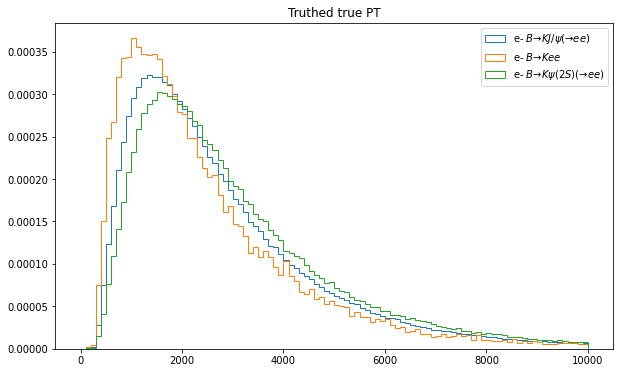

In [29]:
plt.hist(truthed[0]['e_minus_TRUEPT'], label="e- %s"%df_index[0], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
plt.hist(truthed[2]['e_minus_TRUEPT'], label="e- %s"%df_index[2], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
plt.hist(truthed[4]['e_minus_TRUEPT'], label="e- %s"%df_index[4], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
#plt.hist(truthed[0]['e_plus_TRUEPT'], label="e+ %s"%df_index[0], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
#plt.hist(truthed[2]['e_plus_TRUEPT'], label="e+ %s"%df_index[2], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
#plt.hist(truthed[4]['e_plus_TRUEPT'], label="e+ %s"%df_index[4], density=True, bins=np.linspace(0, 10000, 101), histtype='step')
plt.title('Truthed true PT')
plt.legend()
plt.show()

### Preprocessing

In [372]:
x0 = truthed[0]['e_minus_TRUEPT']
x1 = truthed[2]['e_minus_TRUEPT']
x2 = truthed[4]['e_minus_TRUEPT']
y0 = np.zeros_like(x0)
y1 = np.ones_like(x1)
y2 = np.ones_like(x2)*2
X = np.hstack([x0, x1, x2]).reshape(-1, 1)
Y = np.hstack([y0, y1, y2])

In [373]:
x0.shape, x1.shape, x2.shape

((696573,), (40094,), (225328,))

In [374]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)

In [375]:
y_train.mean(), y_test.mean()

(0.5101380811855001, 0.5101351351351351)

In [376]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

### NN

In [377]:
def model():
    return nn.Sequential(
        nn.Linear(1, 20), nn.Tanh(),
        nn.Linear(20, 20), nn.Tanh(),
        nn.Linear(20, 20), nn.Tanh(),
        nn.Linear(20, 3), nn.LogSoftmax(dim=1),
    )

In [378]:
def train(model, loader, epochs=20, weight=None):
    model.train()
    w = torch.as_tensor(weight, dtype=torch.float, device=device)
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.nll_loss(input=pred, target=y, weight=w)
            opt.zero_grad()
            loss.backward()
            opt.step()

In [379]:
dataset = torch.utils.data.TensorDataset(
    torch.as_tensor(scaler.transform(x_train), dtype=torch.float, device=device),
    torch.as_tensor(y_train, dtype=torch.long, device=device)
)
loader = torch.utils.data.DataLoader(dataset, batch_size=10000)

In [380]:
counts = np.asarray([np.sum(y_train==label) for label in [0, 1, 2]])
counts

array([626915,  36085, 202795])

In [381]:
weights = y_train.shape[0]/counts/3
weights

array([0.46034683, 7.99773683, 1.42310379])

In [382]:
m = model().to(device)

In [383]:
train(m, loader, epochs=50, weight=weights)

In [384]:
m.eval()

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=3, bias=True)
  (7): LogSoftmax(dim=1)
)

In [385]:
x = np.linspace(0, 10000, 1001)
x_ = scaler.transform(x.reshape(-1, 1))
y = m(torch.as_tensor(x_, dtype=torch.float, device=device)).detach().cpu().numpy()

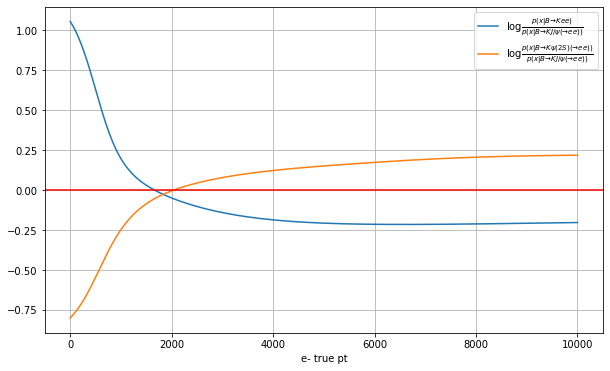

In [386]:
plt.plot(x, y[:,1]-y[:,0], label=r'$\log\frac{p(x|B\to Kee)}{p(x|B\to KJ/\psi(\to ee))}$')
plt.plot(x, y[:,2]-y[:,0], label=r'$\log\frac{p(x|B\to K\psi(2S)(\to ee))}{p(x|B\to KJ/\psi(\to ee))}$')
plt.axhline(0.0, color="r")
plt.grid()
plt.legend()
plt.xlabel('e- true pt')
plt.show()

### Reweighting

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

$$\begin{aligned}
\mathbb{E}_{J/\psi}[w(x)] &= 1
, \\
\mathbb{E}_{\psi(2S)}[w(x)] &= \mathbb{E}_{J/\psi}\left[\frac{p_{\psi(2S)}(x)}{p_{J/\psi}(x)}w(x)\right] = 1
, \\
\mathbb{E}_K[w(x)] &= \mathbb{E}_{J/\psi}\left[\frac{p_K(x)}{p_{J/\psi}(x)}w(x)\right] \to \min_w
.
\end{aligned}$$

In [387]:
def weighting_model():
    return nn.Sequential(
        nn.Linear(1, 20), nn.Tanh(),
        nn.Linear(20, 20), nn.Tanh(),
        nn.Linear(20, 20), nn.Tanh(),
        nn.Linear(20, 1), nn.Tanh(),
    )

In [388]:
def weighting_train(model, loader, epochs=20):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        for batch in loader:
            x, = batch
            prob = m(x)
            pred = model(x)
            p0 = prob[:,0]
            p1 = prob[:,1] - p0
            p2 = prob[:,2] - p0
            loss0 = torch.mean(pred)
            loss2 = torch.mean((1-torch.exp(p2))*pred)
            loss1 = torch.mean((1-torch.exp(p1))*pred)
            loss = loss0**2 + loss2**2 + 1.2*loss1
            opt.zero_grad()
            loss.backward()
            opt.step()

In [389]:
wm = weighting_model().to(device)

In [390]:
dataset0 = torch.utils.data.TensorDataset(
    torch.as_tensor(scaler.transform(x0.reshape(-1,1)), dtype=torch.float, device=device)
)
loader0 = torch.utils.data.DataLoader(dataset0, batch_size=10000)

In [423]:
weighting_train(wm, loader0, epochs=500)

In [424]:
wm.eval()

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
  (7): Tanh()
)

### Checking

In [425]:
def weighting_fn(arr):
    arr_ = scaler.transform(np.asarray(arr).reshape(-1, 1))
    pred = wm(torch.as_tensor(arr_, dtype=torch.float, device=device))[:, 0].detach().cpu().numpy()
    return 1+pred

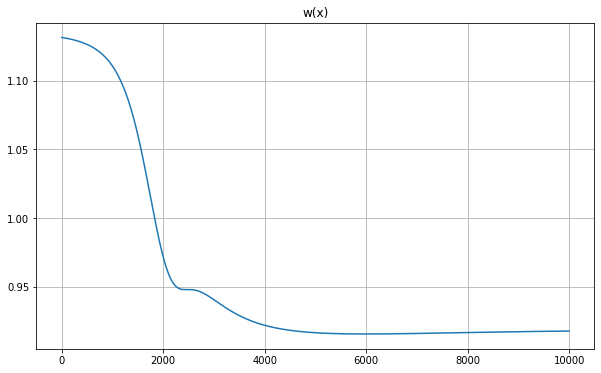

In [426]:
plt.plot(x, weighting_fn(x))
plt.grid()
plt.title("w(x)")
plt.show()

In [427]:
a0 = truthed[0]['e_minus_TRUEPT']
a2 = truthed[2]['e_minus_TRUEPT']
a4 = truthed[4]['e_minus_TRUEPT']
w0 = weighting_fn(a0)
w2 = weighting_fn(a2)
w4 = weighting_fn(a4)
df["w"] = [w0.mean(), 1, w2.mean(), 1, w4.mean(), 1]
df["wTruth"] = df["w"]*df["Truth"]
df

All        B    Truth         w  \
$B \to KJ/\psi(\to ee)$       2084124  1375525   696573  0.990633   
$B \to KJ/\psi(\to\mu\mu)$    3206889  2924782  1459292  1.000000   
$B \to Kee$                    413741   264461    40094  1.006246   
$B \to K\mu\mu$                665455   563948    72469  1.000000   
$B \to K\psi(2S)(\to ee)$      869415   525707   225328  0.979372   
$B \to K\psi(2S)(\to\mu\mu)$  2313029  2059959  1037738  1.000000   

                                    wTruth  
$B \to KJ/\psi(\to ee)$       6.900479e+05  
$B \to KJ/\psi(\to\mu\mu)$    1.459292e+06  
$B \to Kee$                   4.034442e+04  
$B \to K\mu\mu$               7.246900e+04  
$B \to K\psi(2S)(\to ee)$     2.206800e+05  
$B \to K\psi(2S)(\to\mu\mu)$  1.037738e+06

In [428]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.9844835956679076, 1.0114976218626865)

In [429]:
double_ratio(df["Truth"]), double_ratio(df["wTruth"])

(0.8627745334620901, 0.84938737495346)

In [432]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["wTruth"])

(2.1983507867256966, 2.223626592793008)

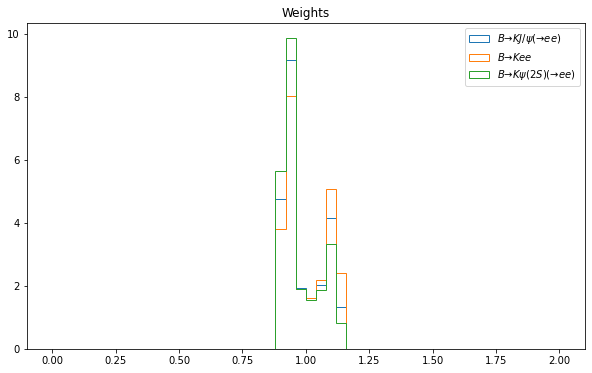

In [430]:
plt.hist(w0, label=df_index[0], density=True, bins=np.linspace(0, 2, 51), histtype='step', cumulative=False)
plt.hist(w2, label=df_index[2], density=True, bins=np.linspace(0, 2, 51), histtype='step', cumulative=False)
plt.hist(w4, label=df_index[4], density=True, bins=np.linspace(0, 2, 51), histtype='step', cumulative=False)
plt.title('Weights')
plt.legend()
plt.show()

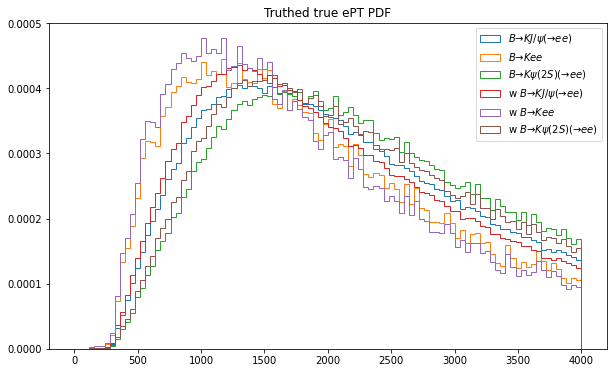

In [431]:
plt.hist(a0, label=df_index[0], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a2, label=df_index[2], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a4, label=df_index[4], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a0, weights=w0, label="w %s"%df_index[0], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a2, weights=w2, label="w %s"%df_index[2], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a4, weights=w4, label="w %s"%df_index[4], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.title('Truthed true ePT PDF')
plt.legend()
plt.show()